# Imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import sys
from IPython.core.display import HTML
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import matplotlib.lines as mlines

In [2]:
sys.path.append('../')

In [3]:
import spacy
from bert_serving.client import BertClient

# Initialize Models

In [4]:
bc = BertClient(output_fmt='list')
nlp = spacy.load("en_core_web_sm", disable=['ner'])

# Create example sentences

Let's try out embeddings on classical word embedding arithmetic example of (King, Queen, Man, Woman) 

## Define Some Functions

In [5]:
def substr_vecs(vec1, vec2):
    return [x-y for x,y in zip(vec1, vec2)]

In [6]:
def style_df(df):
    cm = sns.light_palette("green", as_cmap=True)
    return df.style.background_gradient(cmap=cm)

## Get Embeddings

In [7]:
words = ['woman', 'man', 'queen', 'king']

In [8]:
sents = [f'{item} is eating food.' for item in words + ['somebody']]

In [9]:
sent_embs = bc.encode(sents)

/Users/anz2/anaconda3/envs/case_law/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [12]:
word_embs = bc.encode(words)

In [13]:
subs_word_embs = [substr_vecs(sent_embs[i], sent_embs[-1]) for i in range(4)]

## Compare Substracted Word Embeddings

In [14]:
subs_word_sim_df = pd.DataFrame(cosine_similarity(subs_word_embs, subs_word_embs), columns=words, index=words)

In [15]:
style_df(subs_word_sim_df)

,woman,man,queen,king
woman,1.000000,0.694451,0.766468,0.717144
man,0.694451,1.000000,0.484189,0.605485
queen,0.766468,0.484189,1.000000,0.800824
king,0.717144,0.605485,0.800824,1.000000


## Compare Word Embeddings

In [16]:
word_sim_df = pd.DataFrame(cosine_similarity(word_embs, word_embs), columns=words, index=words)

In [17]:
style_df(word_sim_df)

,woman,man,queen,king
woman,1.000000,0.962678,0.931286,0.916354
man,0.962678,1.000000,0.914590,0.914087
queen,0.931286,0.914590,1.000000,0.967483
king,0.916354,0.914087,0.967483,1.000000


## Compare Subs Word and Word Embeddings

Here we see that embedding of word after subtraction from more general sentence isn't close to original embedding of given word

In [18]:
subs_and_normal_word_sim_df = pd.DataFrame(cosine_similarity(subs_word_embs, word_embs), columns=words, index=words)

In [19]:
style_df(subs_and_normal_word_sim_df)

,woman,man,queen,king
woman,0.215487,0.097508,0.162871,0.157988
man,0.168749,0.156872,0.149363,0.162670
queen,0.101632,0.015137,0.137447,0.132375
king,0.115548,0.081717,0.190927,0.223032


# Test on Countries and Capitals data (Embeddings using fixed sentence context and replacement with general word)

In [20]:
df = pd.read_csv('../data/country_list.csv')

In [21]:
countries = df.country.tolist()

In [22]:
capitals = df.capital.tolist()

In [23]:
len(countries), len(capitals)

(248, 248)

## Get Embeddings

In [24]:
country_sents = [f'Where is {item}.' for item in countries + ['that place']]
capital_sents = [f'Where is {item}.' for item in capitals + ['that place']]

In [25]:
country_sent_embs = bc.encode(country_sents)
capital_sent_embs = bc.encode(capital_sents)

/Users/anz2/anaconda3/envs/case_law/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [26]:
country_embs = bc.encode(countries)
capital_embs = bc.encode(capitals)

In [27]:
subs_country_embs = [substr_vecs(country_sent_embs[i], country_sent_embs[-1]) for i in range(len(countries))]
subs_capital_embs = [substr_vecs(capital_sent_embs[i], capital_sent_embs[-1]) for i in range(len(capitals))]

## Visualize Embeddings in 2D

In [28]:
def visualize_vectors(vectors, names, colors):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(vectors[:, 0], vectors[:, 1])

    for i, (name, color) in enumerate(zip(names, colors)):
        if len(name) > 30:
            name = name[:30] + '...'
        ax.annotate(name, (vectors[i,0], vectors[i,1]), backgroundcolor=color)
    
    n_pairs = int(len(names)/2)
    for p1, p2, n1, n2 in zip(vectors[:n_pairs], vectors[n_pairs:], names[:n_pairs], names[n_pairs:]):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'blue', linestyle='-', marker='')

In [29]:
def embed_pairs_2d(vectors, names, colors=None):
    if not colors:
        colors = ['red' for _ in range(int(len(names)/2))] + ['green' for _ in range(int(len(names)/2))]
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    explained_variances = pca.explained_variance_ratio_
    visualize_vectors(vectors_2d, names, colors)

In [30]:
def get_using_indices(items, indices):
    return [items[i] for i in indices]

## Embeddings of Words (only)

### Show Original Embeddings

In [31]:
random_indices = random.sample(range(len(countries)), 10)

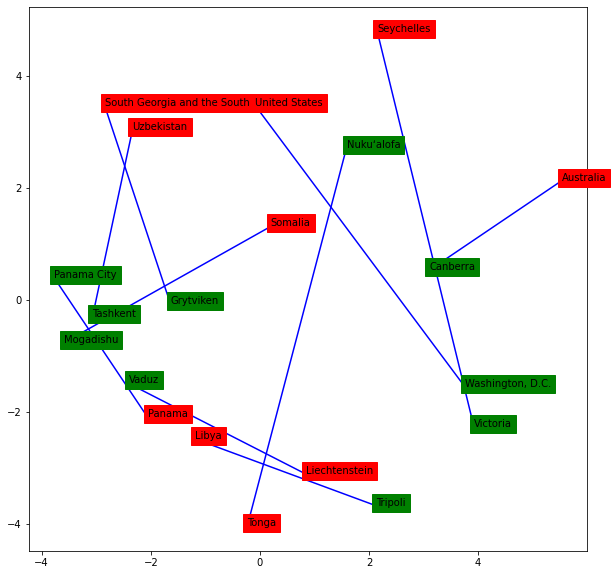

In [32]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

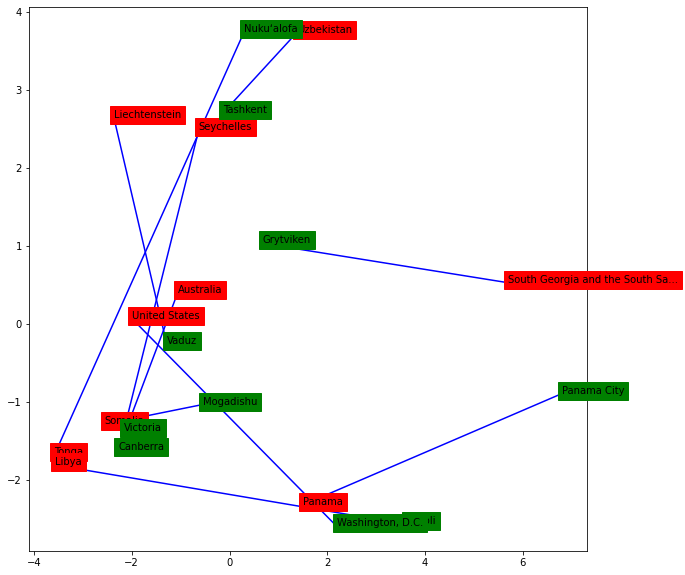

In [33]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [34]:
random_indices = random.sample(range(len(countries)), 10)

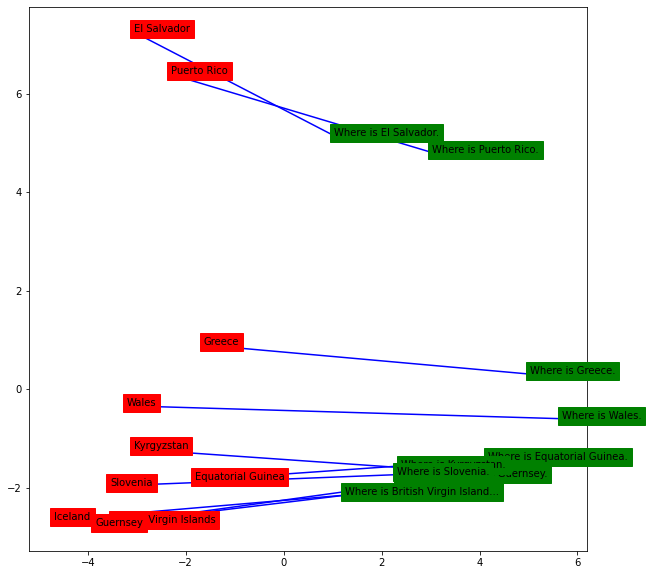

In [35]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

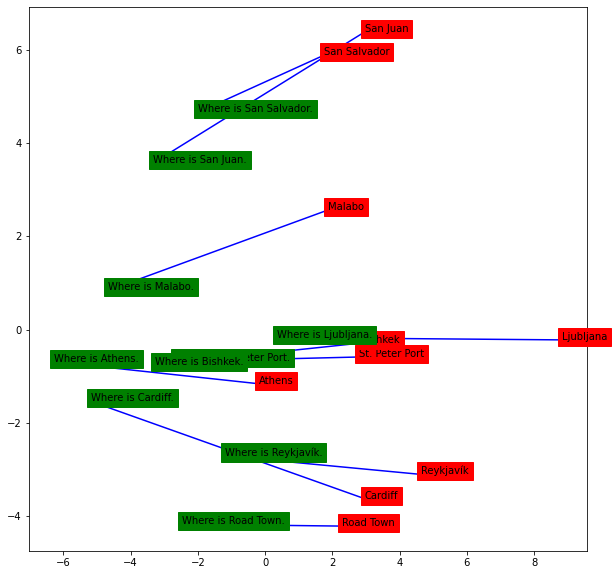

In [36]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

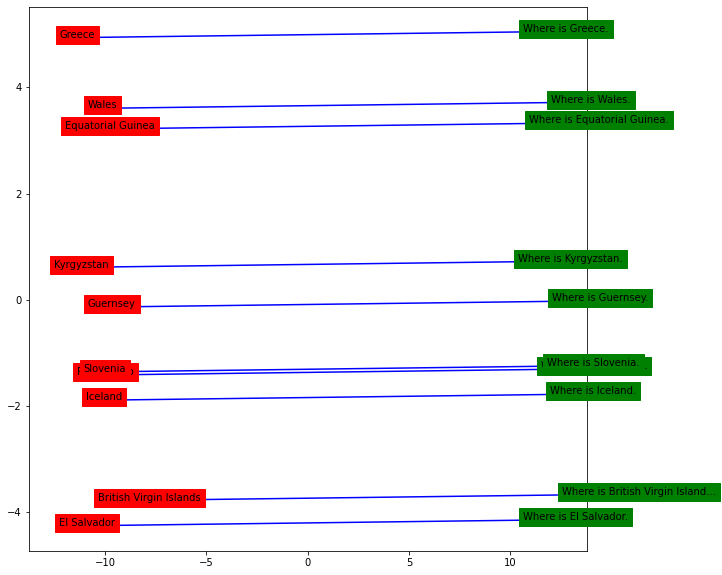

In [37]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

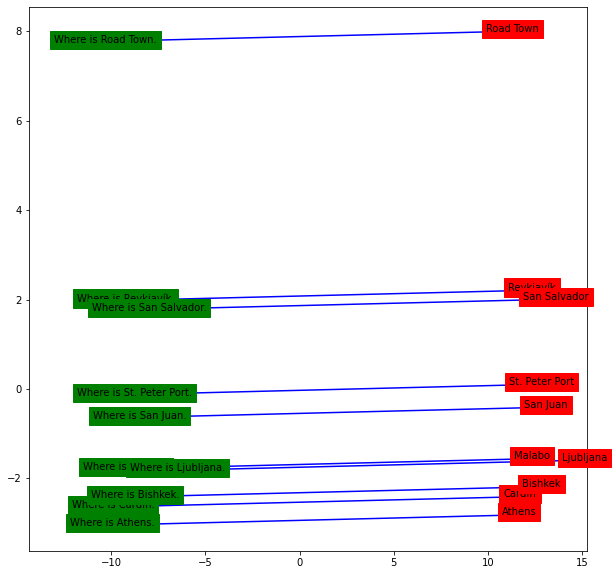

In [38]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

# Test on Countries and Capitals data (Embeddings using randomly chosen sentence context and randomly chosen replacement with general word)

In [39]:
random_sentences = [
    'Where is __REPL__?',
    'How much is the population of __REPL__?',
    'Can you show me __REPL__ on map ?',
    'How many people are living in __REPL__?',
    '__REPL__ is very beautiful place.',
    'How many tourists are in __REPL__.',
    'There are many beautiful parks in __REPL__.',
    '__REPL__ is the best place to eat great food.',
    '__REPL__ is the most popular tourist destination?'
]

In [40]:
REPL = '__REPL__'

In [41]:
def sample(items):
    return random.sample(items, 1)[0]

## Get Embeddings

In [42]:
country_sents = [sample(random_sentences).replace(REPL, item) for item in countries]
country_sents.extend([sent.replace(item, '') for sent, item in zip(country_sents, countries)])

capital_sents = [sample(random_sentences).replace(REPL, item) for item in capitals + ['']]
capital_sents.extend([sent.replace(item, '') for sent, item in zip(capital_sents, capitals)])

In [43]:
country_sent_embs = bc.encode(country_sents)
capital_sent_embs = bc.encode(capital_sents)

/Users/anz2/anaconda3/envs/case_law/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [44]:
country_embs = bc.encode(countries)
capital_embs = bc.encode(capitals)

In [45]:
subs_country_embs = [substr_vecs(country_sent_embs[i], country_sent_embs[len(countries)+i]) 
                     for i in range(len(countries))]
subs_capital_embs = [substr_vecs(capital_sent_embs[i], capital_sent_embs[len(capitals)+i]) 
                     for i in range(len(capitals))]

## Embeddings of Words (only)

### Show Original Embeddings

In [46]:
random_indices = random.sample(range(len(countries)), 10)

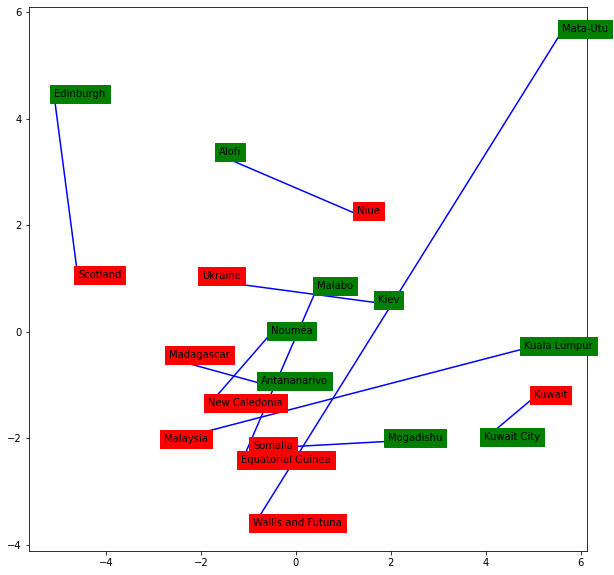

In [47]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

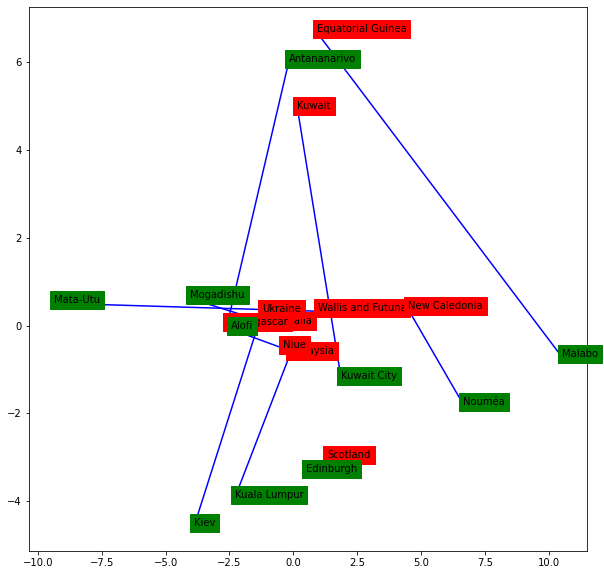

In [48]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [49]:
random_indices = random.sample(range(len(countries)), 10)

#### Countries

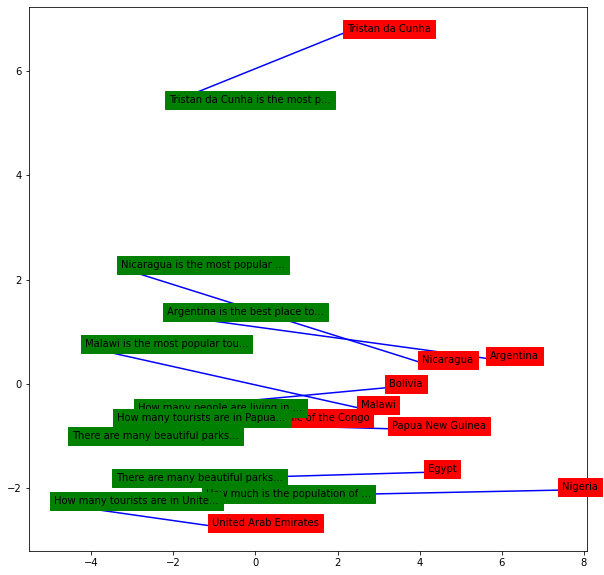

In [50]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### capitals

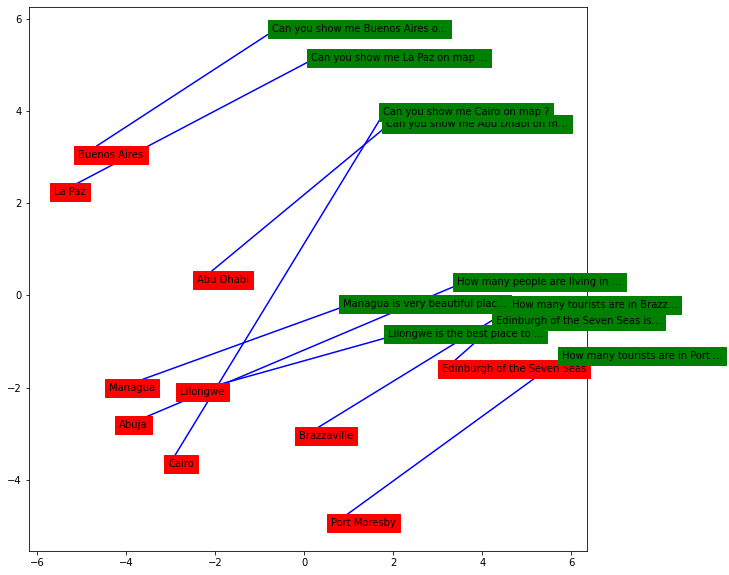

In [51]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

#### Countries

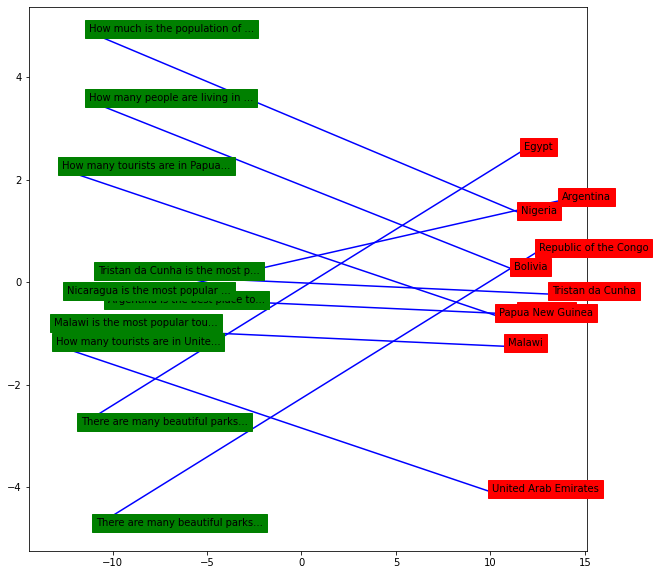

In [52]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### Capitals

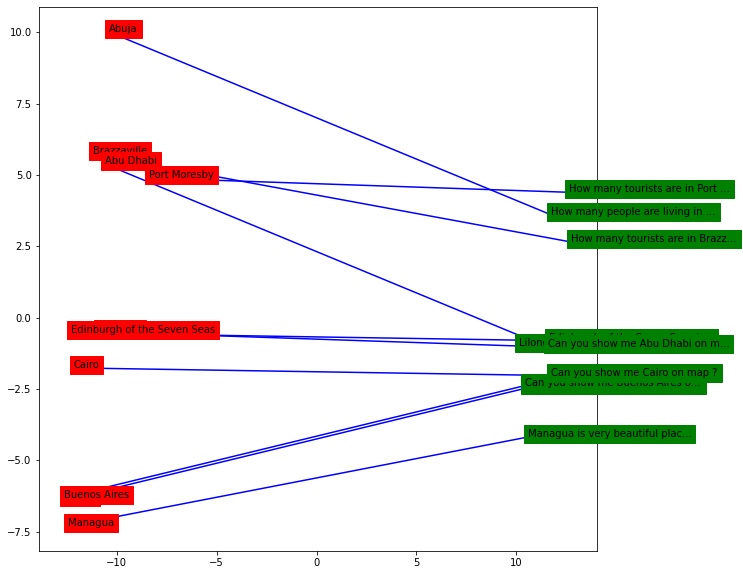

In [53]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

# Test on Countries and Capitals data (Embeddings using randomly chosen document context (multiple occurrences) and randomly chosen replacement with general word)

In [54]:
random_documents = [
    'Where is __REPL__? Many people know things about __REPL__. Many people know about __REPL__ and it is regarded to one of the most wanted and popular for people',
    'How much is the population of __REPL__? Last year there was a huge economical crisis which caused many problems and hence decreased the population. Immigration problems in __REPL__ were started recently which caused additional economical weakness.',
    'Can you show me __REPL__ on map ? I was looking for that yesterday but I did not find __REPL__. Maybe I am using an outdated map which does not allow me to do right query.',
    'How many people are living in __REPL__?',
    '__REPL__ is very beautiful place.',
    'How many tourists are in __REPL__. Previously it was regarded as the best tourist destination. That fact increased number of tourists and had positive impact on __REPL__\'s economy. It opened various jobs for local people actually in tourism.',
    'There are many beautiful parks in __REPL__.',
    '__REPL__ is the best place to eat great food.',
    '__REPL__ is the most popular tourist destination?'
]

In [55]:
REPL = '__REPL__'

In [56]:
def sample(items):
    return random.sample(items, 1)[0]

## Get Embeddings

In [57]:
country_sents = [sample(random_documents).replace(REPL, item) for item in countries]
country_sents.extend([sent.replace(item, '') for sent, item in zip(country_sents, countries)])

capital_sents = [sample(random_documents).replace(REPL, item) for item in capitals + ['']]
capital_sents.extend([sent.replace(item, '') for sent, item in zip(capital_sents, capitals)])

In [58]:
country_sent_embs = bc.encode(country_sents)
capital_sent_embs = bc.encode(capital_sents)

/Users/anz2/anaconda3/envs/case_law/lib/python3.7/site-packages/bert_serving/client/__init__.py:290: UserWarning: server does not put a restriction on "max_seq_len", it will determine "max_seq_len" dynamically according to the sequences in the batch. you can restrict the sequence length on the client side for better efficiency
  warnings.warn('server does not put a restriction on "max_seq_len", '


In [59]:
country_embs = bc.encode(countries)
capital_embs = bc.encode(capitals)

In [60]:
subs_country_embs = [substr_vecs(country_sent_embs[i], country_sent_embs[len(countries)+i]) 
                     for i in range(len(countries))]
subs_capital_embs = [substr_vecs(capital_sent_embs[i], capital_sent_embs[len(capitals)+i]) 
                     for i in range(len(capitals))]

## Embeddings of Words (only)

### Show Original Embeddings

In [61]:
random_indices = random.sample(range(len(countries)), 10)

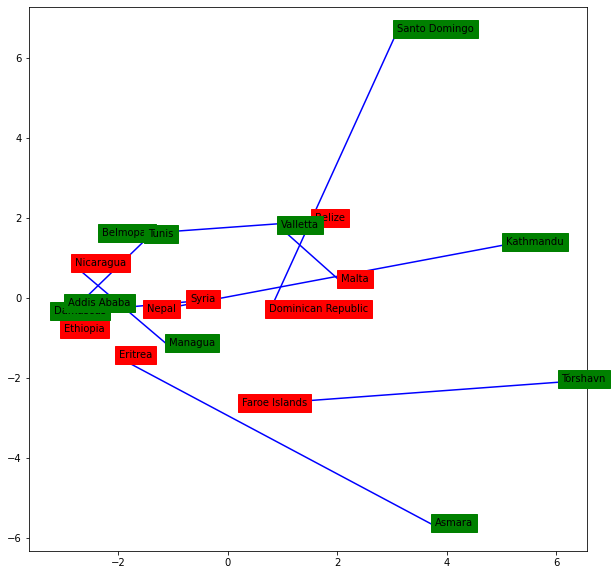

In [62]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

### Show substracted Embeddings

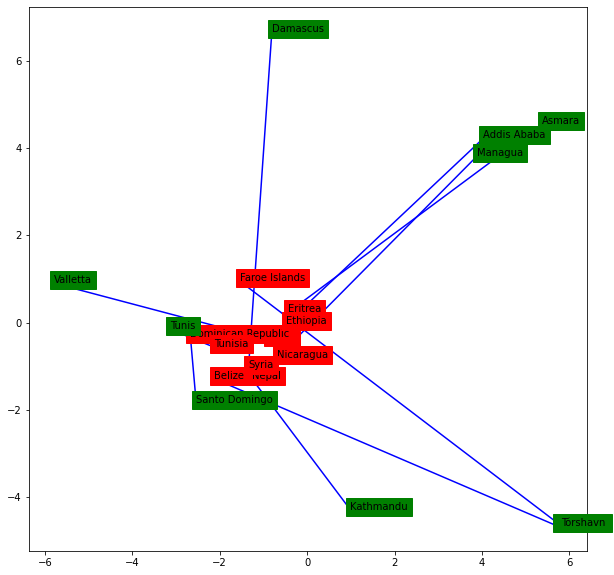

In [63]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(subs_capital_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(capitals, random_indices))

## Embeddings of Words and Sentences

### Show Original Embeddings

In [64]:
random_indices = random.sample(range(len(countries)), 10)

#### Countries

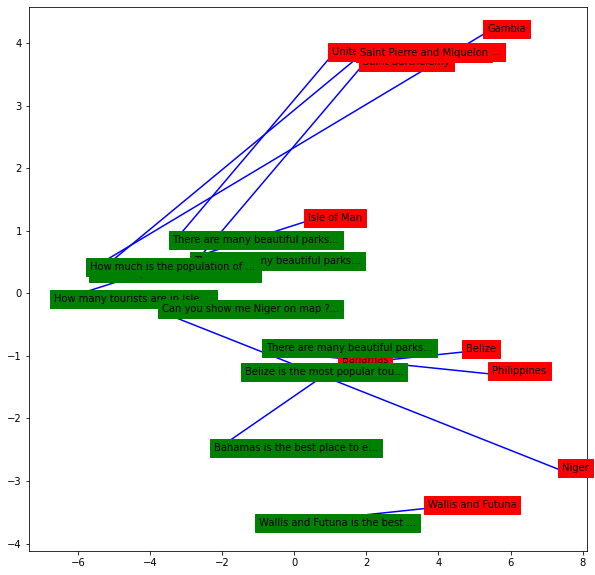

In [65]:
embed_pairs_2d(get_using_indices(country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### capitals

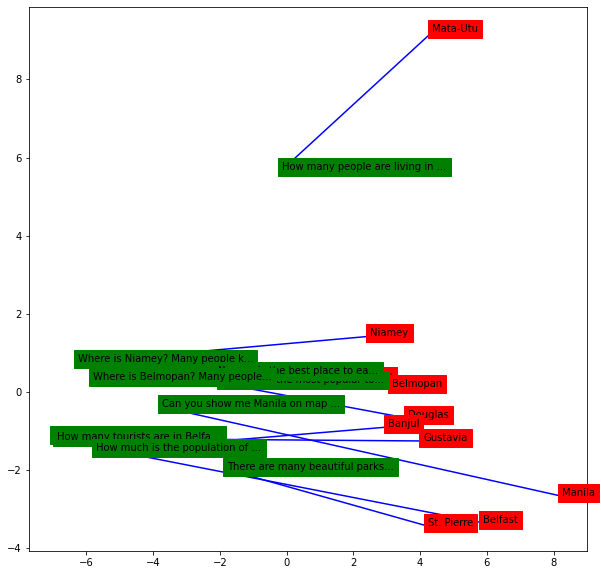

In [66]:
embed_pairs_2d(get_using_indices(capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))

### Show substracted Embeddings

#### Countries

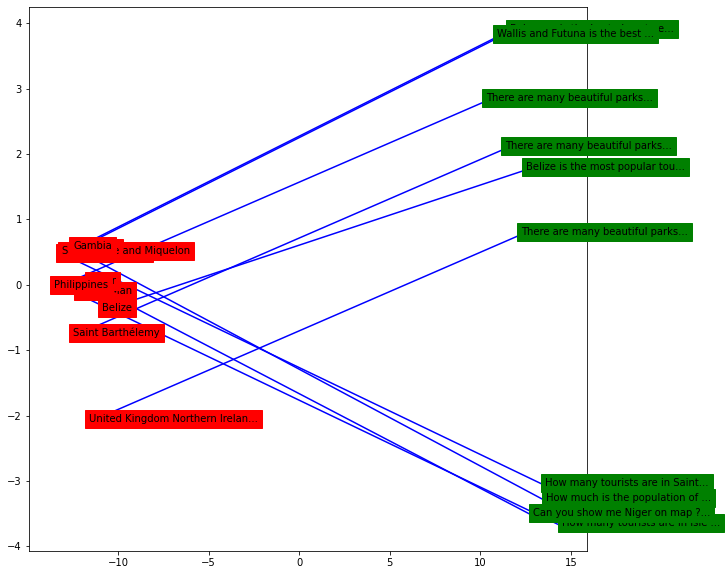

In [67]:
embed_pairs_2d(get_using_indices(subs_country_embs, random_indices) + get_using_indices(country_sent_embs, random_indices),
            get_using_indices(countries, random_indices) + get_using_indices(country_sents, random_indices))

#### Capitals

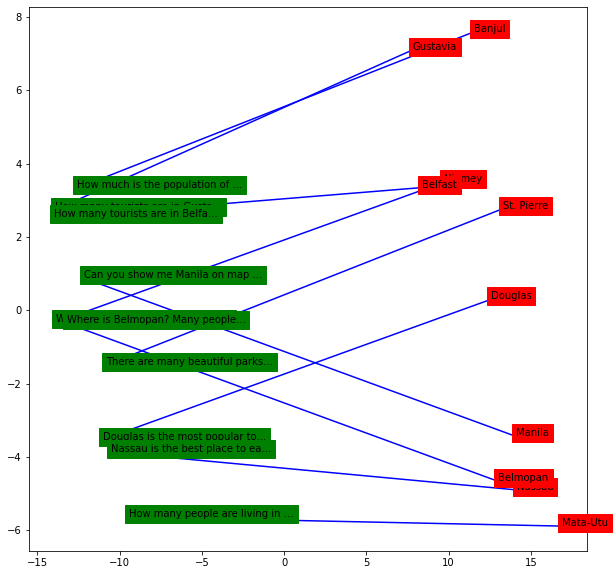

In [68]:
embed_pairs_2d(get_using_indices(subs_capital_embs, random_indices) + get_using_indices(capital_sent_embs, random_indices),
            get_using_indices(capitals, random_indices) + get_using_indices(capital_sents, random_indices))